In [68]:
import pandas as pd
import numpy as np
import datetime 
import re
from urlextract import URLExtract
import spacy
import time
import pickle
import matplotlib.pyplot as plt

In [69]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
extractor = URLExtract()
# remove all urls from posts
def replace_urls(x):
    urls = extractor.find_urls(x)
    if urls:
        x_new = replace_urls(x.replace(urls[0],''))
        return x_new
    else:
        return x

In [71]:
# df_full = pd.read_csv('data/anxiety_full.csv', low_memory=False)
df_full = pd.read_csv('data/depression_full.csv', low_memory=False)

In [72]:
df_full.shape

(201144, 33)

In [73]:
df_full = df_full[(df_full['selftext'] != '[deleted]') & (df_full['selftext'] != '[removed]')].copy()

In [74]:
df_full.drop_duplicates(subset=['selftext'], inplace=True)
df_full.drop_duplicates(subset=['id'], inplace=True)

In [75]:
df_full.shape

(126781, 33)

In [76]:
df_full['date'] = df_full.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

In [77]:
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;#x200B;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;nbsp;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("&amp;",' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub("nbsp;",' ',str(x)))


df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('\n',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: re.sub('  ',' ',str(x)))
df_full['selftext'] = df_full.selftext.map(lambda x: replace_urls(x))
# df_full['date'] = df_full.created_utc.apply(lambda x: pd.to_datetime(time.ctime(x)))

In [78]:
df_full['text_title'] = df_full.title + ' ' + df_full.selftext
df_full['text_title'] = df_full['text_title'].apply(lambda x: str(x))
df_full['text_title'] = df_full['text_title'].apply(lambda x: x.lower())

In [79]:
df_full.groupby('text_title').size().sort_values(ascending=False)
df_full.drop_duplicates(subset=['text_title'], inplace=True)

In [80]:
df_reset = df_full.reset_index().drop(columns=['index'])
df_reset

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,...,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,date,text_title
0,1533158538,Anxiety,HelpfulBush,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/93t5...,1,1,NaN,NaN,Best anxiety apps?,...,True,NaN,/r/Anxiety/comments/93t5va/best_anxiety_apps/,NaN,NaN,False,NaN,NaN,2018-08-01 16:22:18,best anxiety apps? what are the best free anxi...
1,1561404511,Anxiety,kyyface,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/c4u1...,2,1,NaN,NaN,My anxiety is at an all time high...,...,True,NaN,/r/Anxiety/comments/c4u1gb/my_anxiety_is_at_an...,NaN,NaN,False,Venting,NaN,2019-06-24 14:28:31,my anxiety is at an all time high... i’ve alwa...
2,1524380653,Anxiety,Justbecauseweiner,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/8e1q...,31,7,7.0,0.0,Late night anxiousness.,...,True,NaN,/r/Anxiety/comments/8e1qhi/late_night_anxiousn...,t3_8e1qhi,NaN,NaN,NaN,NaN,2018-04-22 02:04:13,late night anxiousness. anyone else up right n...
3,1462453218,Anxiety,Spennner,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/4hzs...,7,3,3.0,0.0,"Male, 24 years old, about to commit the weakes...",...,True,NaN,/r/Anxiety/comments/4hzs7o/male_24_years_old_a...,t3_4hzs7o,NaN,False,NaN,NaN,2016-05-05 08:00:18,"male, 24 years old, about to commit the weakes..."
4,1554417090,Anxiety,AnxietyBoatAllAboard,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/b9jc...,1,2,NaN,NaN,constant work anxiety,...,True,NaN,/r/Anxiety/comments/b9jciy/constant_work_anxiety/,NaN,NaN,False,Work/School,NaN,2019-04-04 17:31:30,constant work anxiety i have constant anxiety ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126771,1519961245,Anxiety,NeverNo,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/81bd...,2,3,NaN,NaN,How many relationships has your anxiety destro...,...,True,NaN,/r/Anxiety/comments/81bdkt/how_many_relationsh...,NaN,NaN,NaN,Relationships,NaN,2018-03-01 21:27:25,how many relationships has your anxiety destro...
126772,1465918564,Anxiety,AnxiousDad73,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/4o1y...,2,1,1.0,0.0,My anxiety increases when i do a cardio workout,...,True,NaN,/r/Anxiety/comments/4o1yy9/my_anxiety_increase...,t3_4o1yy9,GAD/Depression,False,NaN,NaN,2016-06-14 10:36:04,my anxiety increases when i do a cardio workou...
126773,1549876074,Anxiety,Sloppyorange,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/apef...,0,1,NaN,NaN,Someone please help me: I have extreme anxiety...,...,True,NaN,/r/Anxiety/comments/apefsw/someone_please_help...,NaN,NaN,False,Advice Needed,NaN,2019-02-11 03:07:54,someone please help me: i have extreme anxiety...
126774,1497154728,Anxiety,datboy65656565656565,self.Anxiety,https://www.reddit.com/r/Anxiety/comments/6gjk...,1,3,NaN,NaN,I have to attend my cousin's graduation in a f...,...,True,NaN,/r/Anxiety/comments/6gjkwv/i_have_to_attend_my...,NaN,NaN,False,Needs A Hug/Support,NaN,2017-06-10 23:18:48,i have to attend my cousin's graduation in a f...


In [81]:
test = '&amp;nbsp;'
gensim.utils.simple_preprocess(test)

['amp', 'nbsp']

In [2]:
import gensim
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from gensim.models.callbacks import CallbackAny2Vec

In [5]:


class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

loss_logger = LossLogger()
# tqdm.pandas(desc="progress-bar")
# cores = multiprocessing.cpu_count()

# documents = df_reset.text_title
# tokenized_docs = [gensim.utils.simple_preprocess(d) for d in documents]
# model = gensim.models.Word2Vec(tokenized_docs,
#                                size=400,
#                                window=5,
#                                min_count=5,
#                                sg=1,
#                                callbacks=[loss_logger],
#                                compute_loss=True,
#                                iter=35,
#                                workers=cores)

In [206]:
# model.syn0

In [ ]:
# model2.wv.most_similar(['motivation'], topn=30)

In [84]:
# model.save("models/anxiety2vec_full.model")

In [7]:
model = gensim.models.Word2Vec.load("models/anxiety2vec_full.model")
model2 = gensim.models.Word2Vec.load("models/depression2vec_full.model")

In [84]:
model2.wv.most_similar(['motivation'], topn=30)

[('energy', 0.6299775838851929),
 ('willpower', 0.6144546270370483),
 ('ambition', 0.5886609554290771),
 ('motvation', 0.5381804704666138),
 ('modivation', 0.5302222967147827),
 ('motiviation', 0.5192931294441223),
 ('motovation', 0.5171259641647339),
 ('desire', 0.5122600197792053),
 ('enthusiasm', 0.4983682632446289),
 ('motivated', 0.494276225566864),
 ('inspiration', 0.4916467070579529),
 ('unmotivated', 0.4851604998111725),
 ('passion', 0.48500457406044006),
 ('strengh', 0.4655093550682068),
 ('appetite', 0.46231281757354736),
 ('strength', 0.4595683515071869),
 ('zest', 0.45696038007736206),
 ('motivate', 0.4507544934749603),
 ('determination', 0.4479437470436096),
 ('confidence', 0.44607073068618774),
 ('preparedness', 0.4441033601760864),
 ('gumption', 0.44054946303367615),
 ('acomplishment', 0.43923187255859375),
 ('strenght', 0.43693986535072327),
 ('willingness', 0.4365207552909851),
 ('lustre', 0.4341988265514374),
 ('concentration', 0.4321267008781433),
 ('apetite', 0.4266

In [203]:
model.wv.most_similar(positive=['circadian', 'b'], topn=30)

[('sleep', 0.5626819133758545),
 ('hyperarousal', 0.46251243352890015),
 ('nausea', 0.4568025767803192),
 ('fitful', 0.4513145387172699),
 ('sleeping', 0.44332319498062134),
 ('wakefulness', 0.44202369451522827),
 ('dystonia', 0.4266470670700073),
 ('dizziness', 0.4246782064437866),
 ('addison', 0.41871753334999084),
 ('hypermobility', 0.4170190691947937),
 ('rem', 0.4168033003807068),
 ('postural', 0.4120637774467468),
 ('ehlers', 0.4114263951778412),
 ('myoclonic', 0.41049331426620483),
 ('asleep', 0.40417349338531494),
 ('restoril', 0.4024139940738678),
 ('temazepam', 0.40231069922447205),
 ('hypersomnia', 0.40160632133483887),
 ('deprivation', 0.40064889192581177),
 ('chronic', 0.3989311456680298),
 ('fatigue', 0.3986816108226776),
 ('famished', 0.39693641662597656),
 ('gastroparesis', 0.39597469568252563),
 ('restlessly', 0.3947986364364624),
 ('unrested', 0.3925420641899109),
 ('apnea', 0.39095157384872437),
 ('reching', 0.39048999547958374),
 ('chiari', 0.38957351446151733),
 ('

In [204]:
model2.wv.most_similar(positive=['circadian', 'insomnia'], topn=30)

[('somnolence', 0.5951311588287354),
 ('unrefreshing', 0.5921083092689514),
 ('insomina', 0.588383674621582),
 ('wakefulness', 0.5844882130622864),
 ('hypersomnia', 0.5742589235305786),
 ('obstructive', 0.568565845489502),
 ('leaden', 0.5646314024925232),
 ('lpr', 0.5565174221992493),
 ('rem', 0.553957462310791),
 ('premenstrual', 0.5466313362121582),
 ('cystitis', 0.5464724898338318),
 ('minipress', 0.5437217950820923),
 ('amotivation', 0.5436208248138428),
 ('shakiness', 0.5403155088424683),
 ('prazosin', 0.5389235019683838),
 ('pituitary', 0.5361229181289673),
 ('prostatitis', 0.5347299575805664),
 ('dysmenorrhea', 0.5340983867645264),
 ('grogginess', 0.5336235165596008),
 ('hyperthyroidism', 0.5334459543228149),
 ('focalin', 0.531782865524292),
 ('intractable', 0.5309022068977356),
 ('arousals', 0.529588520526886),
 ('sleepiness', 0.5293586254119873),
 ('atrial', 0.5287660956382751),
 ('gerd', 0.5285047292709351),
 ('spd', 0.5272490978240967),
 ('insomia', 0.5268694162368774),
 ('h

In [198]:
model.wv.most_similar(['circadian'], topn=30)

[('sleep', 0.47666364908218384),
 ('rhythm', 0.42202499508857727),
 ('unrested', 0.4173068404197693),
 ('fitful', 0.4103149473667145),
 ('rem', 0.3847265839576721),
 ('depravation', 0.3718340992927551),
 ('deficit', 0.3573581278324127),
 ('insomnia', 0.35166892409324646),
 ('waken', 0.3500707149505615),
 ('addison', 0.34997791051864624),
 ('wakefulness', 0.34935683012008667),
 ('schedule', 0.3488864302635193),
 ('reestablish', 0.3453125059604645),
 ('pituitary', 0.3438349962234497),
 ('myoclonic', 0.343575656414032),
 ('chiari', 0.34182488918304443),
 ('taxed', 0.34070485830307007),
 ('sleeping', 0.33881139755249023),
 ('postural', 0.33795297145843506),
 ('autonomic', 0.33772537112236023),
 ('awaking', 0.33689069747924805),
 ('heats', 0.33540409803390503),
 ('schedual', 0.3346595764160156),
 ('famished', 0.3325856328010559),
 ('unclenching', 0.3308364748954773),
 ('hyperarousal', 0.33080703020095825),
 ('insomniac', 0.33016833662986755),
 ('restful', 0.33013397455215454),
 ('apnea', 0.

In [199]:
model2.wv.most_similar(['circadian'], topn=30)

[('rhythm', 0.567959189414978),
 ('entrainment', 0.5579742789268494),
 ('rhythms', 0.5566973686218262),
 ('arousals', 0.5274004936218262),
 ('wakefulness', 0.5225017070770264),
 ('pituitary', 0.5206567049026489),
 ('bdnf', 0.5151847004890442),
 ('glutamate', 0.5128660202026367),
 ('alertness', 0.5124078392982483),
 ('endocrine', 0.5079496502876282),
 ('hydration', 0.5067459344863892),
 ('overstimulation', 0.5057584047317505),
 ('rem', 0.5053410530090332),
 ('haziness', 0.5034893751144409),
 ('dysregulation', 0.4925832450389862),
 ('cortical', 0.49022603034973145),
 ('synaptic', 0.4869855046272278),
 ('unrefreshing', 0.48379236459732056),
 ('atrial', 0.47749829292297363),
 ('prefrontal', 0.4761282801628113),
 ('alters', 0.47473955154418945),
 ('focalin', 0.47416776418685913),
 ('asanas', 0.47034919261932373),
 ('postural', 0.4698242247104645),
 ('sibo', 0.46905219554901123),
 ('neurogenesis', 0.46842050552368164),
 ('microbiome', 0.4679766893386841),
 ('cingulate', 0.4678953289985657),


In [209]:
model2.wv.most_similar(positive=['sleep'], negative=['insomnia'], topn=20)

[('lay', 0.24297469854354858),
 ('eather', 0.24210433661937714),
 ('bed', 0.23931246995925903),
 ('stayin', 0.2342747300863266),
 ('sleeplessly', 0.2233375608921051),
 ('lather', 0.21556782722473145),
 ('sit', 0.21533411741256714),
 ('dehydrate', 0.21226242184638977),
 ('huddle', 0.21080973744392395),
 ('curl', 0.2105681151151657),
 ('cryed', 0.2104918211698532),
 ('sulk', 0.2095808982849121),
 ('lock', 0.20663698017597198),
 ('pjs', 0.20502379536628723),
 ('asleep', 0.20276586711406708),
 ('grt', 0.20015347003936768),
 ('sleeped', 0.1986388862133026),
 ('unwind', 0.1981518566608429),
 ('asphyxiate', 0.19742079079151154),
 ('minimun', 0.19731174409389496)]

In [210]:
w2c = dict()
for item in model.wv.vocab:
    w2c[item]=model.wv.vocab[item].count

In [216]:
import pandas as pd

In [223]:
df = pd.DataFrame(list(w2c.items()),columns = ['word','count']) 
df[['word', 'count']]

,word,count
0,best,12351
1,anxiety,208758
2,apps,499
3,what,100114
4,are,63934
...,...,...
25990,rodney,18
25991,miguel,6
25992,arkham,5
25993,franchisee,5


In [183]:
# model.wv.similar_by_vector(negative=['psychiatrist', 'prescribed'],topn=20)
# model2.wv.most_similar(positive=['psychiatrist'], negative=['prescribed'], topn=20)
# model2.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20)
model2.wv.most_similar(positive=['addict'], negative=['drugs'], topn=20)



[('alcoholic', 0.33297860622406006),
 ('alcholic', 0.2626097798347473),
 ('stalker', 0.24276447296142578),
 ('freeloader', 0.24215564131736755),
 ('shithead', 0.2369920164346695),
 ('alchoholic', 0.23557531833648682),
 ('fuckwit', 0.22412621974945068),
 ('enabler', 0.2205098569393158),
 ('abuser', 0.21836131811141968),
 ('orphan', 0.21658724546432495),
 ('mouthed', 0.21618300676345825),
 ('wanker', 0.20907407999038696),
 ('seeker', 0.20816045999526978),
 ('junkie', 0.2070085108280182),
 ('understatement', 0.20617571473121643),
 ('thief', 0.20612667500972748),
 ('psychopathic', 0.20595476031303406),
 ('loser', 0.20561592280864716),
 ('narcissist', 0.20457029342651367),
 ('sicko', 0.2019149214029312)]

In [185]:
diff = model.wv['sleep'] - model.wv['prescribed']
model.wv.similar_by_vector(diff,topn=20)



[('insomnia', 0.8722215890884399),
 ('sleep', 0.8283430337905884),
 ('sleeping', 0.5788544416427612),
 ('asleep', 0.5290964245796204),
 ('nausea', 0.49453288316726685),
 ('circadian', 0.4812701940536499),
 ('restoril', 0.4718226492404938),
 ('hyperarousal', 0.46199142932891846),
 ('appetite', 0.4604637920856476),
 ('awake', 0.45851007103919983),
 ('nights', 0.4446353614330292),
 ('fitful', 0.43999016284942627),
 ('temazepam', 0.43586477637290955),
 ('mares', 0.42881038784980774),
 ('jetlag', 0.42802882194519043),
 ('night', 0.4269375205039978),
 ('slept', 0.42618077993392944),
 ('wakefulness', 0.42589688301086426),
 ('dizziness', 0.4254881739616394),
 ('sleeplessness', 0.42475250363349915)]

In [43]:
# man_wom = model.wv['psychiatrist'] - model.wv['meds'] 
# model.wv.similar_by_vector(man_wom,topn=20)

diff = model.wv['psychiatrist'] - model.wv['meds']
model.wv.similar_by_vector(diff,topn=10)


[('psychiatrist', 0.6058940291404724),
 ('psychologist', 0.453220933675766),
 ('therapist', 0.44538718461990356),
 ('counselor', 0.4171057343482971),
 ('doctor', 0.3817121386528015),
 ('gp', 0.3656955361366272),
 ('physiatrist', 0.34224098920822144),
 ('physician', 0.30193591117858887),
 ('opthalmologist', 0.2976304888725281),
 ('urologist', 0.2969989776611328)]

In [154]:
model.wv.most_similar(positive=['cry', 'frustration'], negative=['sad'], topn=20)
# model2.wv.most_similar(positive=['cry', 'frustration'], negative=['sad'], topn=20)


[('scream', 0.4388599991798401),
 ('punch', 0.33786454796791077),
 ('anger', 0.32701078057289124),
 ('tears', 0.3185722529888153),
 ('thrash', 0.31270092725753784),
 ('crying', 0.30638131499290466),
 ('rage', 0.3007892668247223),
 ('lash', 0.2961653470993042),
 ('bawl', 0.29389554262161255),
 ('sheer', 0.28733697533607483),
 ('sobbing', 0.27876782417297363),
 ('wail', 0.2766817808151245),
 ('rip', 0.2749730944633484),
 ('bawling', 0.27308955788612366),
 ('yell', 0.27242252230644226),
 ('vomit', 0.2722880244255066),
 ('punching', 0.2709498703479767),
 ('burst', 0.2680802643299103),
 ('gulps', 0.2678743600845337),
 ('curl', 0.262950599193573)]

In [125]:
model2.wv.most_similar(positive=['cry', 'frustration'], negative=['sad'], topn=20)


[('anger', 0.43362170457839966),
 ('rage', 0.40245386958122253),
 ('scream', 0.3819226920604706),
 ('wail', 0.3624647855758667),
 ('frustrations', 0.35270392894744873),
 ('resentment', 0.3517230153083801),
 ('crying', 0.3339613378047943),
 ('groan', 0.3325698971748352),
 ('hatred', 0.3315785825252533),
 ('bawl', 0.33156394958496094),
 ('drench', 0.33120957016944885),
 ('whimper', 0.3275694251060486),
 ('cried', 0.32559311389923096),
 ('shear', 0.325377494096756),
 ('unleash', 0.3189791440963745),
 ('curdling', 0.31834590435028076),
 ('saddnes', 0.3181757628917694),
 ('defensiveness', 0.317504346370697),
 ('overflows', 0.31660544872283936),
 ('pent', 0.3139970898628235)]

In [42]:
model2.wv.most_similar(positive=['cry', 'anxious'], negative=['sad'], topn=20)


[('crying', 0.39194464683532715),
 ('nervous', 0.38030683994293213),
 ('hyperventilate', 0.3797268867492676),
 ('cried', 0.356989324092865),
 ('panicky', 0.35588353872299194),
 ('shakey', 0.33299189805984497),
 ('sobbing', 0.328744113445282),
 ('bawl', 0.32808876037597656),
 ('heaving', 0.31815457344055176),
 ('attacks', 0.3146486282348633),
 ('startle', 0.3142939507961273),
 ('crouch', 0.3120366930961609),
 ('nausious', 0.3094452917575836),
 ('panic', 0.306612104177475),
 ('scream', 0.30297374725341797),
 ('heave', 0.3026064932346344),
 ('retch', 0.3016483783721924),
 ('hyperventilated', 0.29968297481536865),
 ('spazzing', 0.2962726056575775),
 ('weeping', 0.2943868041038513)]

In [41]:
# model.most_similar(positive=['paris', 'australia'], negative=['france'], topn=10)
model.wv.most_similar(positive=['cry', 'anxious'], negative=['sad'], topn=20)
# print()
# print(model2.wv.most_similar(positive=['cry', 'nervous'], negative=['sad'], topn=20))

# diff = model.wv['psychiatrist'] - model.wv['therapist']
# diff2 = model2.wv['psychiatrist'] - model2.wv['therapist']
# print(model.wv.similar_by_vector(diff,topn=10))
# print()
# print(model2.wv.similar_by_vector(diff2,topn=10))

[('nervous', 0.3819749355316162),
 ('sweat', 0.3713247776031494),
 ('scream', 0.367182195186615),
 ('vomit', 0.36197972297668457),
 ('crying', 0.35808974504470825),
 ('nauseous', 0.35409674048423767),
 ('hyperventilate', 0.33382436633110046),
 ('throw', 0.3329312205314636),
 ('panicky', 0.33205458521842957),
 ('tremble', 0.3284249007701874),
 ('thrash', 0.3222140967845917),
 ('squirm', 0.31927067041397095),
 ('worry', 0.3176902234554291),
 ('panicked', 0.3168250620365143),
 ('panicking', 0.3159446716308594),
 ('seizes', 0.31565237045288086),
 ('restlessly', 0.3155618906021118),
 ('tears', 0.30303144454956055),
 ('bawl', 0.3029019832611084),
 ('defecate', 0.29996174573898315)]

In [458]:
diff = model2.wv['addict'] - model2.wv['drugs']
model2.wv.similar_by_vector(diff,topn=20)

[('addict', 0.6733916401863098),
 ('alcoholic', 0.4120483696460724),
 ('alcholic', 0.3180551826953888),
 ('alchoholic', 0.2982047498226166),
 ('junkie', 0.2741677761077881),
 ('enabler', 0.2727421820163727),
 ('freeloader', 0.2725487947463989),
 ('abuser', 0.26774370670318604),
 ('stalker', 0.2676283121109009),
 ('shithead', 0.26650702953338623),
 ('fuckwit', 0.2555328905582428),
 ('orphan', 0.25468891859054565),
 ('seeker', 0.25299978256225586),
 ('drunkard', 0.24964818358421326),
 ('mouthed', 0.24752940237522125),
 ('narcissist', 0.24744683504104614),
 ('psychopathic', 0.24710029363632202),
 ('manipulator', 0.2415054440498352),
 ('wanker', 0.23988217115402222),
 ('lier', 0.23946475982666016)]

In [89]:
print(model.wv.most_similar(['addict'], topn=50))

[('drug', 0.469160795211792), ('alcoholic', 0.46443772315979004), ('heroin', 0.43080058693885803), ('addiction', 0.4193027913570404), ('druggie', 0.3963623642921448), ('opiate', 0.3945620656013489), ('meth', 0.39068734645843506), ('abuse', 0.355867475271225), ('enabler', 0.3490749001502991), ('addicts', 0.34255698323249817), ('methadone', 0.3423783779144287), ('seeker', 0.3361815810203552), ('oxycodone', 0.33102577924728394), ('junkie', 0.327989399433136), ('addicted', 0.32739943265914917), ('abused', 0.32622241973876953), ('alcoholics', 0.3261690139770508), ('felon', 0.3255310654640198), ('alcoholism', 0.32128578424453735), ('narcotics', 0.31861862540245056), ('suboxone', 0.3161890208721161), ('heroine', 0.30493849515914917), ('porn', 0.3038252592086792), ('methamphetamine', 0.30095574259757996), ('smoker', 0.2991180419921875), ('drinker', 0.2989364564418793), ('complainer', 0.29300469160079956), ('idiot', 0.2919292151927948), ('crutch', 0.2909916043281555), ('drugs', 0.28707543015480

In [90]:
diff = model.wv['alcoholic'] - model.wv['alcohol']
model.wv.similar_by_vector(diff,topn=10)


[('alcoholic', 0.7425734996795654),
 ('abusive', 0.3379460871219635),
 ('addict', 0.2977589964866638),
 ('arguement', 0.27292490005493164),
 ('scammed', 0.2637854218482971),
 ('narcissistic', 0.26005345582962036),
 ('dad', 0.25782108306884766),
 ('divorced', 0.2562631070613861),
 ('father', 0.24566684663295746),
 ('stepdad', 0.24473626911640167)]

In [180]:
# man_wom = model.wv['sex'] - model.wv['partner'] 
# model.wv.similar_by_vector(man_wom,topn=20)
man_wom = model2.wv['addict'] - model2.wv['drugs'] 
model2.wv.similar_by_vector(man_wom,topn=20)

[('addict', 0.6733916401863098),
 ('alcoholic', 0.4120483696460724),
 ('alcholic', 0.3180551826953888),
 ('alchoholic', 0.2982047498226166),
 ('junkie', 0.2741677761077881),
 ('enabler', 0.2727421820163727),
 ('freeloader', 0.2725487947463989),
 ('abuser', 0.26774370670318604),
 ('stalker', 0.2676283121109009),
 ('shithead', 0.26650702953338623),
 ('fuckwit', 0.2555328905582428),
 ('orphan', 0.25468891859054565),
 ('seeker', 0.25299978256225586),
 ('drunkard', 0.24964818358421326),
 ('mouthed', 0.24752940237522125),
 ('narcissist', 0.24744683504104614),
 ('psychopathic', 0.24710029363632202),
 ('manipulator', 0.2415054440498352),
 ('wanker', 0.23988217115402222),
 ('lier', 0.23946475982666016)]

In [30]:
man_wom = model.wv['home'] - model.wv['good'] 
model.wv.similar_by_vector(man_wom,topn=20)
# names = []
# vals = []

# for item in simvecs:
#     names.append(item[0])
#     vals.append(item[1])


    
# man_wom2 = model2.wv['addict'] - model2.wv['drugs'] 
# simvecs2 = model2.wv.similar_by_vector(man_wom2,topn=20)
# names2 = []
# vals2 = []

# for item in simvecs2:
#     names2.append(item[0])
#     vals2.append(item[1])
    
    

[('home', 0.6776692271232605),
 ('house', 0.2571713924407959),
 ('hometown', 0.2533918619155884),
 ('apartment', 0.2508479356765747),
 ('courthouse', 0.24342043697834015),
 ('nebraska', 0.24190139770507812),
 ('donuts', 0.2303203046321869),
 ('wawa', 0.22885316610336304),
 ('hotel', 0.22734153270721436),
 ('detour', 0.22647640109062195),
 ('explorer', 0.22098472714424133),
 ('kilometers', 0.21982544660568237),
 ('overseas', 0.21878460049629211),
 ('nans', 0.2183181643486023),
 ('dunkin', 0.21745258569717407),
 ('mns', 0.21161328256130219),
 ('wales', 0.21135979890823364),
 ('tram', 0.21128252148628235),
 ('angie', 0.21119913458824158),
 ('car', 0.21045488119125366)]

In [462]:
# fig, ax = plt.subplots(figsize=[10, 8])
# plt.title('addict - drugs', color='white', fontsize=15)
# ax.barh(names2[::-2], vals2[::-2], color = 'orange')

# ax.axes.tick_params(axis="y", colors='white', labelsize=15)
# ax.axes.tick_params(axis="x", colors="white", labelsize=10)
# plt.savefig('graph3.png', transparent=True, dpi=300)

In [460]:
names2

['addict',
 'alcoholic',
 'alcholic',
 'alchoholic',
 'junkie',
 'enabler',
 'freeloader',
 'abuser',
 'stalker',
 'shithead',
 'fuckwit',
 'orphan',
 'seeker',
 'drunkard',
 'mouthed',
 'narcissist',
 'psychopathic',
 'manipulator',
 'wanker',
 'lier']

In [450]:

fig, ax = plt.subplots(figsize=[10, 8])
plt.title('addiction - drugs', color='white', fontsize=15)
ax.barh(names[::-2], vals[::-2], color = 'orange')

ax.axes.tick_params(axis="y", colors='white', labelsize=15)
ax.axes.tick_params(axis="x", colors="white", labelsize=10)
plt.savefig('graph2.png', transparent=True, dpi=300)

In [46]:
man_wom = model.wv['need'] - model.wv['want'] 
model.wv.similar_by_vector(man_wom,topn=20)

[('need', 0.5421233177185059),
 ('needed', 0.4064671993255615),
 ('needing', 0.3301694989204407),
 ('reassurance', 0.27454960346221924),
 ('needs', 0.269459992647171),
 ('urgently', 0.2560148239135742),
 ('brotha', 0.25420570373535156),
 ('assurance', 0.2503100633621216),
 ('necessary', 0.2470582127571106),
 ('guidance', 0.24680472910404205),
 ('profesional', 0.23446135222911835),
 ('unbiased', 0.2293991595506668),
 ('relocation', 0.2289716601371765),
 ('commiseration', 0.22886931896209717),
 ('urgent', 0.22775787115097046),
 ('asinine', 0.2271844744682312),
 ('glean', 0.2233790159225464),
 ('saught', 0.22306659817695618),
 ('counceling', 0.22179396450519562),
 ('tipps', 0.22020339965820312)]

In [93]:
model.wv.most_similar('dead', topn=20)

[('die', 0.3843366503715515),
 ('died', 0.38023027777671814),
 ('dying', 0.3480793237686157),
 ('killed', 0.33431774377822876),
 ('perry', 0.32132482528686523),
 ('farce', 0.30476123094558716),
 ('bundling', 0.29651960730552673),
 ('frigid', 0.2954271733760834),
 ('cremated', 0.2945195436477661),
 ('clutched', 0.29045289754867554),
 ('spaniel', 0.29021742939949036),
 ('motionless', 0.28876975178718567),
 ('splinters', 0.2875170111656189),
 ('corpse', 0.28733059763908386),
 ('beetle', 0.2857452929019928),
 ('deer', 0.28557074069976807),
 ('bombshell', 0.28502655029296875),
 ('reborn', 0.28432855010032654),
 ('mining', 0.28151267766952515),
 ('collapses', 0.2803266942501068)]

In [276]:
man_wom = model.wv['friend'] - model.wv['love']
model.wv.similar_by_vector(man_wom,topn=20)

[('friend', 0.5932840704917908),
 ('roommate', 0.29324641823768616),
 ('coworker', 0.2641681432723999),
 ('cousin', 0.24512945115566254),
 ('invited', 0.23886226117610931),
 ('friends', 0.23793013393878937),
 ('classmate', 0.23626333475112915),
 ('guest', 0.22579124569892883),
 ('acquaintance', 0.2181546986103058),
 ('roommates', 0.2178659439086914),
 ('colleague', 0.21560321748256683),
 ('bff', 0.21553850173950195),
 ('mates', 0.2144087851047516),
 ('snitch', 0.21318280696868896),
 ('member', 0.21312469244003296),
 ('buddy', 0.2110852301120758),
 ('boyfriend', 0.21022632718086243),
 ('sister', 0.20855426788330078),
 ('mom', 0.20567438006401062),
 ('ra', 0.20301009714603424)]

In [277]:
man_wom = model.wv['gender'] - model.wv['identity'] 
model.wv.similar_by_vector(man_wom,topn=20)

[('gender', 0.6417267918586731),
 ('dysphoria', 0.21997776627540588),
 ('cultures', 0.1915351152420044),
 ('girls', 0.18292824923992157),
 ('germs', 0.17764028906822205),
 ('boys', 0.17688800394535065),
 ('hygienist', 0.1764385849237442),
 ('causal', 0.1757318377494812),
 ('nonbinary', 0.17540894448757172),
 ('asian', 0.1744622141122818),
 ('women', 0.1737489104270935),
 ('websites', 0.17140163481235504),
 ('shoved', 0.17010046541690826),
 ('virgin', 0.16930550336837769),
 ('outrageous', 0.16813811659812927),
 ('location', 0.16515594720840454),
 ('halter', 0.16500529646873474),
 ('conservative', 0.16415444016456604),
 ('nonchalant', 0.16408485174179077),
 ('patron', 0.1637495458126068)]

In [98]:
# psych = model.wv['pyschiatrist']
# meds = model.wv['meds']


In [204]:
# doc_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
# doc_model

In [221]:
df_full.text_title

0         my bday today. treated myself to a full cake. ...
1         is it normal for depression to last so long? i...
4         i need help hi it’s my first time here and i’m...
5         morning depression i have really bad morning d...
8         how about those grandparents !!! yesterday was...
                                ...                        
199989    how dare they i'm 21. struggled with depressio...
199991    my depression but make it sexual assault lol w...
199996    its been 140 days its been 140 since my attemp...
199997    i wish i could teleport back to the old ages. ...
199998    i don’t want to do anything i have an exam on ...
Name: text_title, Length: 117378, dtype: object

In [374]:
# # anxiety = model.wv['anxious']
# import seaborn as sns

# sns.set_theme(style="whitegrid")
# a = model.wv['psychiatrist']
# b = model.wv['prescribed']

# x = a - b

# x2 = model.wv['therapist']

# # fig = plt.figure(figsize=[15,15])
# # ax = ax.gca(projection='3d')
# fig, ax = plt.subplots(figsize=[10, 8])
# V = np.array([a, b, x2])
# origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

# ax.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=.7)
# # plt.xlim([-.002, .002])
# # plt.show()
# # model.wv.similar_by_vector(x)

# ax.axes.tick_params(axis="y", colors='white', labelsize=10)
# ax.axes.tick_params(axis="x", colors="white", labelsize=10)
# plt.grid(False)
# plt.savefig('vecs.png', transparent=True, dpi=300)


In [257]:
# x, y  = [1, 2, 3], [0.5, 0.5, 0.5]
# u1,v1 = np.random.randn(3), np.random.randn(3)
# u2,v2 = np.random.randn(3), np.random.randn(3)
# u3,v3 = np.random.randn(3), np.random.randn(3)

# QV1 = plt.quiver(x, y, u1, v1, color='r')
# QV2 = plt.quiver(x, y, u2, v2, color='b')
# QV3 = plt.quiver(x, y, u3, v3, color='g')

In [136]:
zero = np.zeros(400,)

In [225]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

documents = df_reset.text_title
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in documents]

# data = df_full.text_title

# tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
# tagged_data[1:10]

In [ ]:
# model= Doc2Vec.load("d2v.model")

In [1437]:
# tag documents
data = df_reset.text_title   
docs = []
for i, doc in enumerate(data):
    docs.append(TaggedDocument(words=doc.split(), tags=[str(i)]))

In [1438]:
# tagged_data[1:10]
len(docs)

60111

In [1483]:
# define parameters for doc2vec
doc_model = gensim.models.Doc2Vec(
                                  vector_size=300,
                                  window=5,
                                  min_count=5,
                                  workers=cores,
                                  epochs=35,
                                  alpha=.025,
                                  min_alpha = 0.0001)
doc_model.build_vocab(docs)

In [1484]:
# train model
doc_model.train(docs, total_examples=model.corpus_count, epochs=model.epochs)

In [1485]:
docs[0].tags

['0']

In [763]:
# ranks = []
# second_ranks = []
# for doc_id in range(len(docs)):
#     inferred_vector = doc_model.infer_vector(docs[doc_id].words)
#     sims = doc_model.docvecs.most_similar([inferred_vector], topn=len(doc_model.docvecs))
#     rank = [docid for docid, sim in sims].index(str(doc_id))
#     ranks.append(rank)

#     second_ranks.append(sims[1])

In [764]:
# import collections

# counter = collections.Counter(ranks)
# print(counter)

In [594]:
# doc_model.save("doc2vec.model")

In [1489]:
testing = """
Does anyone else get bothered when people say they’re feeling manic or acting manic when they’re not bipolar?
I just got diagnosed this year with bipolar 2. It really bothers me when people say they’re going manic or acting it when they’re not bi polar at all. Or when people say they’re bi polar just because they’re in a mood.

Don’t mind me. Just venting away as I snack lol
"""
testing = gensim.utils.simple_preprocess(testing)

In [1490]:
# doc2vec_best = gensim.models.Word2Vec.load("models/doc2vec.model")

In [1491]:
# from gensim.models.doc2vec import Doc2Vec
new_vector = doc_model.infer_vector(testing)
sims = doc_model.docvecs.most_similar([new_vector])
sims


[('10951', 0.5179792046546936),
 ('43157', 0.5052784085273743),
 ('54200', 0.4878782033920288),
 ('30806', 0.4802919924259186),
 ('58801', 0.4742465913295746),
 ('912', 0.473446249961853),
 ('43760', 0.47278130054473877),
 ('29264', 0.47181829810142517),
 ('6909', 0.47102224826812744),
 ('19415', 0.4650293290615082)]

In [1492]:
# from gensim.models.doc2vec import Doc2Vec
# new_vector = doc2vec_best.infer_vector(testing)
# sims = doc2vec_best.docvecs.most_similar([new_vector])
# sims

[('180494', 0.39420461654663086),
 ('175533', 0.38218963146209717),
 ('140476', 0.37668436765670776),
 ('75540', 0.3756507635116577),
 ('55942', 0.3647383749485016),
 ('141121', 0.3565114736557007),
 ('28763', 0.3537557125091553),
 ('37483', 0.3517759442329407),
 ('163016', 0.34997788071632385),
 ('59592', 0.3493573069572449)]

In [1495]:
' '.join(docs[43157][0])

'extreme breakdowns when hungry asking for a friend: usually a calm, happy, enthusiastic person. but when they get hungry, they get extremely angry and irritated. they begin to get irrational thoughts and self-describe as "my life feels like shit" and feel hopeless. they describe these incidents as traumatic. they don\'t want to be around people or do anything. this happens when even mildly not eating enough- like after 2-3 hours after a meal. what could this be?'

In [ ]:
# ranks = []
# second_ranks = []
# for doc_id in range(len(tagged_data)):
#     inferred_vector = doc_model.infer_vector(tagged_data[doc_id].words)
#     sims = doc_model.docvecs.most_similar([inferred_vector], topn=len(doc_model.docvecs))
#     rank = [docid for docid, sim in sims].index(doc_id)
#     ranks.append(rank)

#     second_ranks.append(sims[1])

In [1290]:
# doc_model.most_similar['hate']

TypeError: 'method' object is not subscriptable

In [534]:
tagged_data[183903][0]

['i',
 'loved',
 'her',
 'so',
 'much',
 'she',
 'meant',
 'everything',
 'to',
 'me',
 '.',
 'she',
 'was',
 'the',
 'reason',
 'i',
 'got',
 'up',
 'in',
 'the',
 'morning',
 ',',
 'the',
 'reason',
 'i',
 'looked',
 'forward',
 'into',
 'the',
 'future',
 '.',
 'she',
 'was',
 'the',
 'only',
 'person',
 'i',
 'could',
 'truly',
 'be',
 'myself',
 'with',
 '.',
 'i',
 'would',
 'give',
 'anything',
 'to',
 'go',
 'back',
 'to',
 'the',
 'times',
 'we',
 'were',
 'still',
 'together',
 '.',
 'but',
 'i',
 'messed',
 'up',
 'too',
 'bad',
 '.',
 'since',
 'one',
 'of',
 'her',
 'relatives',
 'died',
 'she',
 'became',
 'depressed',
 'and',
 'i',
 'did',
 "n't",
 'realise',
 'it',
 'and',
 'put',
 'myself',
 'as',
 'a',
 'priority',
 '.',
 'worst',
 'mistake',
 'of',
 'my',
 'life',
 '.',
 'and',
 'i',
 'did',
 'this',
 'multiple',
 'times',
 'without',
 'realising',
 'too',
 '.',
 'i',
 'deserve',
 'that',
 'she',
 'broke',
 'up',
 'with',
 'me',
 ',',
 'i',
 'deserve',
 'this',
 'dep

In [513]:
new_vector = doc_model.infer_vector(test)
sims = doc_model.docvecs.most_similar([new_vector])
sims

[('52459', 0.24828779697418213),
 ('3679', 0.2148471623659134),
 ('111671', 0.20974236726760864),
 ('116430', 0.20800384879112244),
 ('21543', 0.20616112649440765),
 ('69029', 0.20351946353912354),
 ('17204', 0.20307250320911407),
 ('78466', 0.20283262431621552),
 ('38693', 0.19461870193481445),
 ('94048', 0.19434437155723572)]

In [511]:
tagged_data[8160]

TaggedDocument(words=['never', 'quite', 'understood', 'depression', '...', 'until', 'now', '.', 'i', '’', 've', 'literally', 'been', 'in', 'a', 'downward', 'spiral', 'mentally', 'since', 'september', '.', 'i', '’', 've', 'pushed', 'some', 'of', 'my', 'friends', 'away', 'over', 'time', '..', 'partly', 'because', 'i', 'felt', 'that', 'some', 'weren', '’', 't', 'really', 'my', 'friends', ',', 'but', 'others', 'jus', 'cause', 'life', 'takes', 'us', 'in', 'different', 'directions', '.', 'loneliness', 'is', 'something', 'i', '’', 've', 'come', 'to', 'accept', 'and', 'hate', '.', 'the', 'career', 'i', '’', 've', 'been', 'working', 'towards', 'feels', 'like', 'a', 'lost', 'cause', ',', 'and', 'i', 'fear', 'failing', 'out', 'of', 'grad', 'school', '.', 'i', '’', 've', 'never', 'felt', 'my', 'thoughts', 'get', 'so', 'interrupted', 'before', '.', 'interrupted', 'by', 'mainly', 'a', 'feeling', 'of', 'hopelessness', '.', 'i', 'find', 'no', 'passion', 'in', 'what', 'i', 'study', ',', 'and', 'school'

In [259]:
model = gensim.models.Word2Vec.load("models/anxiety2vec_full.model")
model2 = gensim.models.Word2Vec.load("models/depression2vec_full.model")

words = []
counts =[]
w2v = model
for index in range(len(w2v.wv.index2word)):
    word = w2v.wv.index2word[index]
    words.append(word)
    counts.append(w2v.wv.vocab[word].count)
    
# pd.DataFrame({'word':words, 'count':counts}).to_csv('tensor_data/anxiety/anxiety_meta.tsv', index=False,sep=' ' )

import io

# Vector file, `\t` seperated the vectors and `\n` seperate the words
# """
# 0.1\t0.2\t0.5\t0.9
# 0.2\t0.1\t5.0\t0.2
# 0.4\t0.1\t7.0\t0.8
# """

path2 = '/Users/collinswestnedge/programming/project_05/tensor_data/anxiety/anxiety_'

# out_v = io.open(path2+'vecs.tsv', 'w', encoding='utf-8')

# Meta data file, `\n` seperated word
# """
# token1
# token2
# token3
# """
# out_m = io.open(path2+'meta.tsv', 'w', encoding='utf-8')

# Write meta file and vector file
for index in range(len(w2v.wv.index2word)):
    word = w2v.wv.index2word[index]
    vec = w2v.wv.vectors[index]
    count = w2v.wv.vocab[word].count
#     out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,docs,num_comments
0,-0.044936,0.520540,0.297664,-0.633278,-0.639522,1.324903,-0.572327,-0.123448,-1.326039,1.022799,...,1.476781,1.022502,0.630570,0.282395,-0.189325,0.277642,-0.254412,-0.453682,i miss having good days i'm looking at a reall...,4
1,-0.915679,0.197295,0.394015,-0.364234,0.008477,-0.170550,-0.080744,-0.664542,-1.037869,0.653916,...,0.256806,0.040021,-0.768031,-0.181038,-0.050529,0.544944,0.055534,-0.602254,i feel like i don't belong firstly i must say ...,3
2,-1.389762,0.417339,0.569990,0.131901,0.367433,0.128845,-0.341438,-0.608718,-0.395197,-0.190117,...,-0.292848,0.368557,1.021488,0.427908,-0.050864,-1.787373,-0.747154,-0.388342,i just read a post here someone on here said t...,0
3,-0.069560,0.432485,1.350291,-0.808754,-1.195333,0.878532,0.483246,0.614651,0.318892,0.881236,...,-1.459201,-1.160588,0.692426,-0.498555,0.001215,0.312774,0.623916,0.255476,everything is falling apart in life and i'm ti...,0
4,0.552676,0.075528,0.283143,-0.457708,0.237152,0.366468,-0.007420,0.031663,-0.646435,0.389935,...,-0.040199,0.328641,-0.713822,-0.428586,0.300699,0.446857,-0.438353,-0.583585,for the first time in 2 years i've started wan...,1


In [819]:
doc_vec_df = pd.DataFrame(doc_model.docvecs.vectors_docs)
doc_vec_df['num_comments'] = df_reset.num_comments
doc_vec_df['docs'] = df_reset.text_title
doc_vec_df.head()

cols= [str(i) for i in range(doc_model.docvecs.vectors_docs.shape[1])]
cols.append('num_comments')
cols.append('docs')

doc_vec_df.columns = cols
doc_vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,num_comments,docs
0,-0.044936,0.520540,0.297664,-0.633278,-0.639522,1.324903,-0.572327,-0.123448,-1.326039,1.022799,...,1.476781,1.022502,0.630570,0.282395,-0.189325,0.277642,-0.254412,-0.453682,4,i miss having good days i'm looking at a reall...
1,-0.915679,0.197295,0.394015,-0.364234,0.008477,-0.170550,-0.080744,-0.664542,-1.037869,0.653916,...,0.256806,0.040021,-0.768031,-0.181038,-0.050529,0.544944,0.055534,-0.602254,3,i feel like i don't belong firstly i must say ...
2,-1.389762,0.417339,0.569990,0.131901,0.367433,0.128845,-0.341438,-0.608718,-0.395197,-0.190117,...,-0.292848,0.368557,1.021488,0.427908,-0.050864,-1.787373,-0.747154,-0.388342,0,i just read a post here someone on here said t...
3,-0.069560,0.432485,1.350291,-0.808754,-1.195333,0.878532,0.483246,0.614651,0.318892,0.881236,...,-1.459201,-1.160588,0.692426,-0.498555,0.001215,0.312774,0.623916,0.255476,0,everything is falling apart in life and i'm ti...
4,0.552676,0.075528,0.283143,-0.457708,0.237152,0.366468,-0.007420,0.031663,-0.646435,0.389935,...,-0.040199,0.328641,-0.713822,-0.428586,0.300699,0.446857,-0.438353,-0.583585,1,for the first time in 2 years i've started wan...


In [822]:
doc_vec_df.iloc[:,0:-2]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.044936,0.520540,0.297664,-0.633278,-0.639522,1.324903,-0.572327,-0.123448,-1.326039,1.022799,...,0.502041,0.742274,1.476781,1.022502,0.630570,0.282395,-0.189325,0.277642,-0.254412,-0.453682
1,-0.915679,0.197295,0.394015,-0.364234,0.008477,-0.170550,-0.080744,-0.664542,-1.037869,0.653916,...,0.824775,-0.478621,0.256806,0.040021,-0.768031,-0.181038,-0.050529,0.544944,0.055534,-0.602254
2,-1.389762,0.417339,0.569990,0.131901,0.367433,0.128845,-0.341438,-0.608718,-0.395197,-0.190117,...,0.207874,1.057422,-0.292848,0.368557,1.021488,0.427908,-0.050864,-1.787373,-0.747154,-0.388342
3,-0.069560,0.432485,1.350291,-0.808754,-1.195333,0.878532,0.483246,0.614651,0.318892,0.881236,...,-0.045553,0.953733,-1.459201,-1.160588,0.692426,-0.498555,0.001215,0.312774,0.623916,0.255476
4,0.552676,0.075528,0.283143,-0.457708,0.237152,0.366468,-0.007420,0.031663,-0.646435,0.389935,...,0.134260,-0.156145,-0.040199,0.328641,-0.713822,-0.428586,0.300699,0.446857,-0.438353,-0.583585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201352,0.298886,0.197538,-1.344621,0.500490,0.220331,0.197895,-0.020537,0.081666,0.181198,-0.076670,...,0.027662,0.178918,1.145354,-0.087398,-0.049152,-0.351741,0.202527,0.068889,-0.270401,0.126972
201353,-0.602596,0.377942,0.085982,-0.337944,0.449444,0.074730,-0.225704,-0.201027,0.582127,0.235354,...,0.019660,0.710241,0.053188,-0.577499,-0.259348,-0.568318,0.079483,-0.000426,-0.238406,-0.316102
201354,-0.065782,0.442552,0.095001,-0.093407,-0.216463,0.219249,-0.140672,-0.025479,-0.165297,0.122063,...,0.392786,0.174501,0.092954,0.176399,-0.276574,-0.063548,0.544563,-0.152216,0.060663,0.155498
201355,-1.123527,1.239098,-0.538115,0.291597,-0.859328,-0.666605,-0.884606,0.280054,-0.898989,-0.767195,...,-0.872320,1.616813,0.040773,1.471004,-1.165609,0.006591,0.587708,1.030469,-0.090478,0.318005


In [926]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

# to normalise existing X
X_Norm = preprocessing.normalize(doc_vec_df.iloc[:,0:-2], axis=1)
X_Norm

kmeans = KMeans(n_clusters=40, random_state=0).fit(X_Norm)

In [927]:
kmeans.labels_

array([ 5, 25,  4, ..., 31, 13,  9], dtype=int32)

In [946]:
doc_vec_df['labels'] = kmeans.labels_
doc_vec_df[doc_vec_df.labels == 1]['docs'].values[3]

'i feel depressed i am gonna be 12 soon and am getting to stretch out a bit and i am feeling mildly depressed during the day and its way worse at night i don’t know what to do my parents think i’m lying help?'

In [863]:
inertia = []
sil = []
# changing the number of clusters 
for k in range(5,30):
    
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_Norm)
    y_pred = km.predict(X_Norm)
    inertia.append((k, km.inertia_))
    print(k)

Text(0.5, 1.0, 'Elbow Curve')

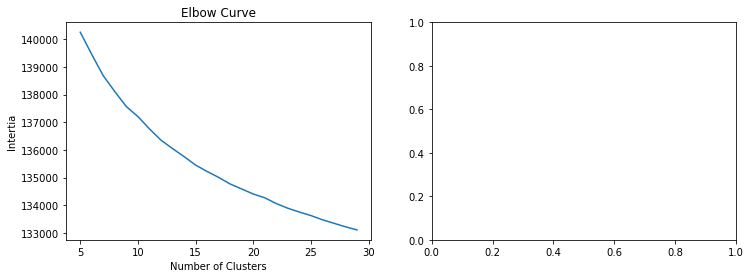

In [866]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,4))

# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')
ax[0].set_title('Elbow Curve')

